In [ ]:
## only run if using google Colab
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/FCN')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## personal .py files
import utils

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
#utils.write_to_record('train.tfrecords', 'Data/train.txt', 'Data/Images', 'Data/Labels', verbose=True)
#utils.write_to_record('val.tfrecords', 'Data/val.txt', 'Data/Images', 'Data/Labels', verbose=True)

In [ ]:
train_dataset = utils.read_from_record('train.tfrecords')
val_dataset = utils.read_from_record('val.tfrecords')

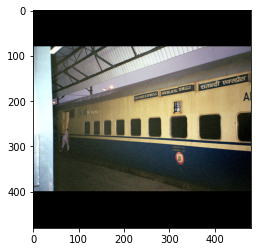

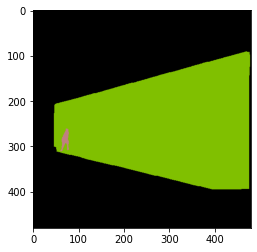

In [ ]:
for X, y in val_dataset.take(1):
  utils.display_image(X)
  utils.display_image(y)

In [ ]:
class BilinearInitializer(tf.keras.initializers.Initializer):

  def __init__(self):
    pass

  def __call__(self, shape, dtype=None):
    kernel_size, _, n, m = shape

    ## make filter that performs bilinear interpolation through Conv2DTranspose
    upscale_factor = (kernel_size+1)//2
    if kernel_size % 2 == 1:
      center = upscale_factor - 1
    else:
      center = upscale_factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    kernel = (1-np.abs(og[0]-center)/upscale_factor) * (1-np.abs(og[1]-center)/upscale_factor) 
    ## kernel shape is (kernel_size, kernel_size)

    kernel = np.repeat(kernel[:,:,np.newaxis], n, axis=-1)
    kernel = np.repeat(kernel[:,:,:,np.newaxis], m, axis=-1)
    return tf.convert_to_tensor(kernel, dtype=dtype)

  def get_config(self):
    return {}



class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  ## https://github.com/tensorflow/tensorflow/issues/32875
  
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
## load VGG16 base model, converting FC layers to convolutional layers and adding dropout
## ==================================================
dropout_rate = 0.5
input_shape = (480, 480)
#input_shape = (224, 224)
## ==================================================

x = keras.Input(shape=(*input_shape, 3), name='input')
x = keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, name='preprocessing')(x)

base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=x)
x = keras.layers.Conv2D(4096, 7, activation='relu', padding='same', name='conv6')(base_model.layers[-1].output)
x = keras.layers.Dropout(dropout_rate, name='drop6')(x)
x = keras.layers.Conv2D(4096, 1, activation='relu', name='conv7')(x)
x = keras.layers.Dropout(dropout_rate, name='drop7')(x)
x = keras.layers.Conv2D(1000, 1, activation='softmax', name='predictions')(x)
base_model = keras.Model(base_model.input, x)

## set FC weights
full_model = keras.applications.vgg16.VGG16(weights='imagenet')

W = np.array(full_model.get_layer('fc1').weights[0]).reshape(7, 7, 512, 4096)
b = np.array(full_model.get_layer('fc1').weights[1])
base_model.get_layer('conv6').set_weights((W, b))

W = np.array(full_model.get_layer('fc2').weights[0]).reshape(1, 1, 4096, 4096)
b = np.array(full_model.get_layer('fc2').weights[1])
base_model.get_layer('conv7').set_weights((W, b))

W = np.array(full_model.get_layer('predictions').weights[0]).reshape(1, 1, 4096, 1000)
b = np.array(full_model.get_layer('predictions').weights[1])
base_model.get_layer('predictions').set_weights((W, b))

## freeze layers
for L in base_model.layers:
  L.trainable = False

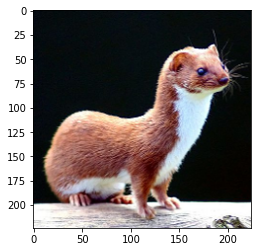

Guess: weasel. Prob: 0.700
Guess: polecat, fitch, foulmart, foumart, Mustela putorius. Prob: 0.170
Guess: mink. Prob: 0.123
Guess: black-footed ferret, ferret, Mustela nigripes. Prob: 0.007
Guess: otter. Prob: 0.000


In [ ]:
## Test base model
## !!! input_shape needs to be (224, 224) !!!
from imagenet_classes import class_names

arr = utils.get_image('laska.png', out_dims=(224, 224))
utils.display_image(arr)

probs = base_model.predict(arr[np.newaxis,:,:,:])[0, 3, 3] # pick central prediction from 7 x 7 square
pred = np.argsort(probs)[::-1]
for i in range(5):
  c = pred[i]
  print("Guess: %s. Prob: %.3f" % (class_names[c], probs[c]))

In [ ]:
## Build FCN32
num_classes = 21

x = keras.layers.Conv2D(filters=num_classes, 
                        kernel_size=1, 
                        kernel_initializer=keras.initializers.Zeros(),
                        kernel_regularizer=keras.regularizers.L2(1e-5),
                        name='score7')(base_model.get_layer('drop7').output)

x = keras.layers.Conv2DTranspose(filters=num_classes, 
                                 kernel_size=64, 
                                 strides=32, 
                                 padding='same',
                                 use_bias=False, 
                                 kernel_initializer=BilinearInitializer(),
                                 kernel_regularizer=keras.regularizers.L2(1e-5),
                                 name='fcn32')(x)

x = keras.layers.Softmax(axis=-1, name='predictions')(x)

model_32 = keras.Model(base_model.input, x)              

In [ ]:
model_32.load_weights('checkpoint_32s_30e.h5')

In [ ]:
## Build FCN16
model_32.get_layer('score7').trainable=False

x = keras.layers.Conv2DTranspose(filters=num_classes, 
                                 kernel_size=4, 
                                 strides=2, 
                                 padding='same',
                                 use_bias=False, 
                                 kernel_initializer=BilinearInitializer(),
                                 kernel_regularizer=keras.regularizers.L2(1e-5),
                                 name='score7_upsample')(model_32.get_layer('score7').output)

y = keras.layers.Conv2D(filters=num_classes, 
                        kernel_size=1, 
                        kernel_initializer=keras.initializers.Zeros(),
                        kernel_regularizer=keras.regularizers.L2(1e-5),
                        name='score4')(base_model.get_layer('block4_pool').output)

x = keras.layers.Add(name='skip4')([x, y])

x = keras.layers.Conv2DTranspose(filters=num_classes, 
                                 kernel_size=32, 
                                 strides=16, 
                                 padding='same',
                                 use_bias=False, 
                                 kernel_initializer=BilinearInitializer(),
                                 kernel_regularizer=keras.regularizers.L2(1e-5),
                                 name='fcn16')(x)

x = keras.layers.Softmax(axis=-1, name='predictions')(x)

model_16 = keras.Model(base_model.input, x)

In [ ]:
model_16.load_weights('checkpoint_16s_30e.h5')

In [ ]:
model_16.get_layer('score7_upsample').trainable=False
model_16.get_layer('score4').trainable=False

x = keras.layers.Conv2DTranspose(filters=num_classes, 
                                 kernel_size=4, 
                                 strides=2, 
                                 padding='same',
                                 use_bias=False, 
                                 kernel_initializer=BilinearInitializer(),
                                 kernel_regularizer=keras.regularizers.L2(1e-5),
                                 name='skip4_upsample')(model_16.get_layer('skip4').output)

y = keras.layers.Conv2D(filters=num_classes, 
                        kernel_size=1, 
                        kernel_initializer=keras.initializers.Zeros(),
                        kernel_regularizer=keras.regularizers.L2(1e-5),
                        name='score3')(base_model.get_layer('block3_pool').output)

x = keras.layers.Add(name='skip3')([x, y])

x = keras.layers.Conv2DTranspose(filters=num_classes, 
                                 kernel_size=16, 
                                 strides=8, 
                                 padding='same',
                                 use_bias=False, 
                                 kernel_initializer=BilinearInitializer(),
                                 kernel_regularizer=keras.regularizers.L2(1e-5),
                                 name='fcn8')(x)

x = keras.layers.Softmax(axis=-1, name='predictions')(x)

model_8 = keras.Model(base_model.input, x)

In [ ]:
## Train model

model = model_8
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
preprocessing (Lambda)          (None, 480, 480, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 480, 64) 1792        preprocessing[0][0]              
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 480, 64) 36928       block1_conv1[0][0]               
___________________________________________________________________________________________

In [ ]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#  initial_learning_rate=1e-4, 
#  decay_steps=steps_per_epoch, 
#  decay_rate=0.9)
#opt = keras.optimizers.Adam(learning_rate=lr_schedule)
opt = keras.optimizers.Adam(learning_rate=1e-4)

loss = keras.losses.SparseCategoricalCrossentropy()

metrics = [loss, UpdatedMeanIoU(num_classes=21)]

model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [ ]:
## check running GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
train_gen = train_dataset.shuffle(1000).batch(20)
val_gen = val_dataset.shuffle(2857).batch(32)

In [ ]:
model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
425/425 [==============================] - 381s 893ms/step - loss: 0.4540 - sparse_categorical_crossentropy: 0.3166 - updated_mean_io_u_1: 0.5293 - val_loss: 0.4573 - val_sparse_categorical_crossentropy: 0.3189 - val_updated_mean_io_u_1: 0.4971
Epoch 2/10
425/425 [==============================] - 381s 894ms/step - loss: 0.4596 - sparse_categorical_crossentropy: 0.3223 - updated_mean_io_u_1: 0.5212 - val_loss: 0.4611 - val_sparse_categorical_crossentropy: 0.3239 - val_updated_mean_io_u_1: 0.4966
Epoch 3/10
425/425 [==============================] - 381s 893ms/step - loss: 0.4560 - sparse_categorical_crossentropy: 0.3188 - updated_mean_io_u_1: 0.5270 - val_loss: 0.4576 - val_sparse_categorical_crossentropy: 0.3197 - val_updated_mean_io_u_1: 0.5108
Epoch 4/10
425/425 [==============================] - 381s 893ms/step - loss: 0.4574 - sparse_categorical_crossentropy: 0.3202 - updated_mean_io_u_1: 0.5211 - val_loss: 0.4671 - val_sparse_categorical_crossentropy: 0.3308 - val_upda

In [ ]:
model.save_weights('checkpoint_8s_30e.h5')

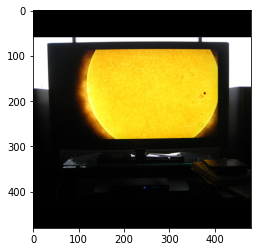

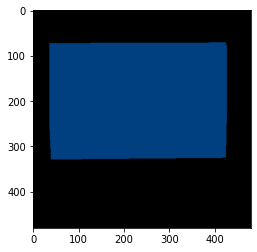

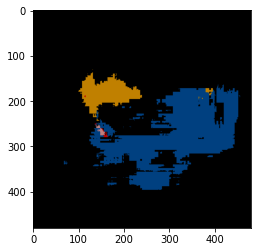

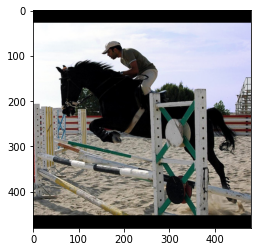

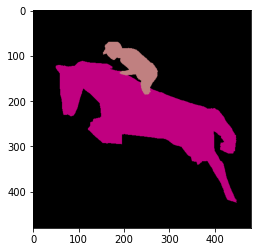

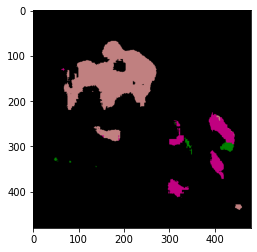

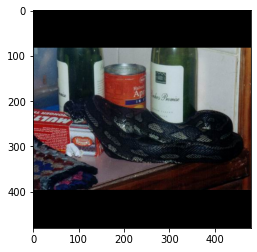

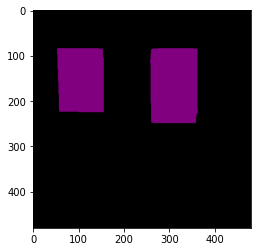

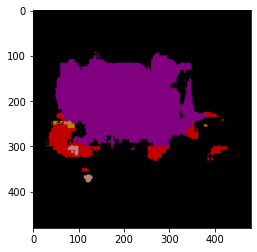

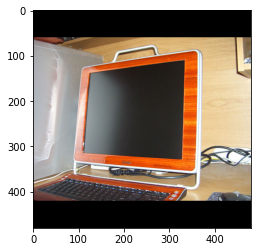

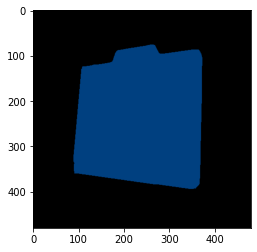

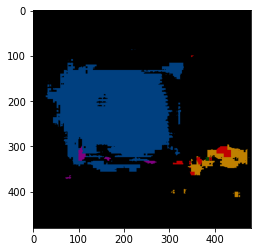

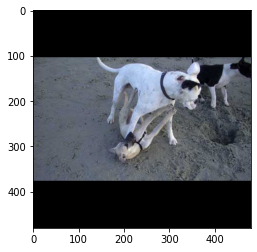

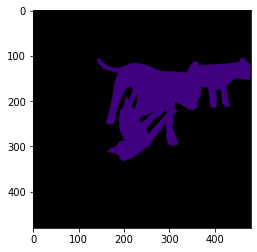

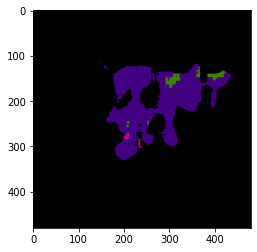

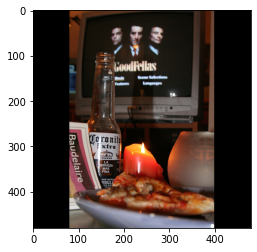

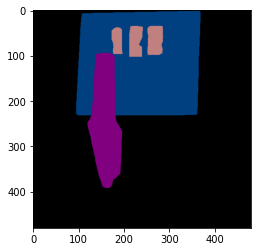

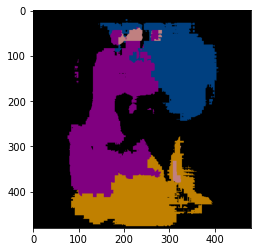

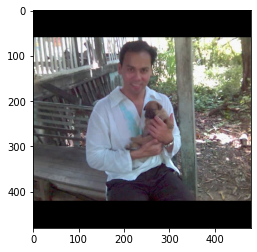

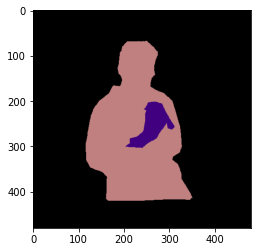

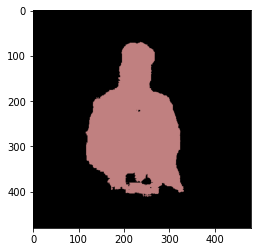

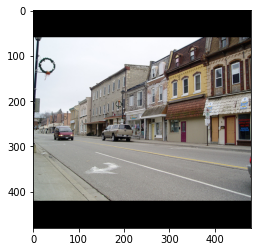

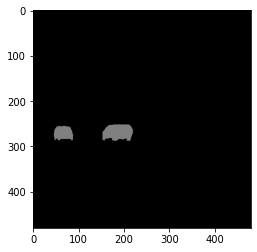

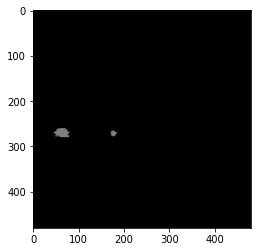

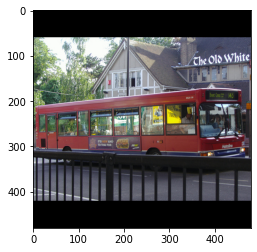

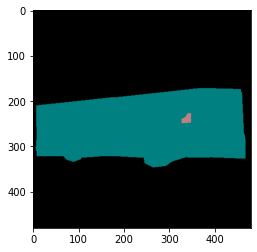

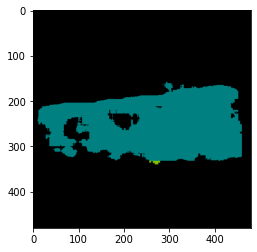

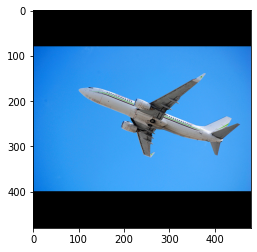

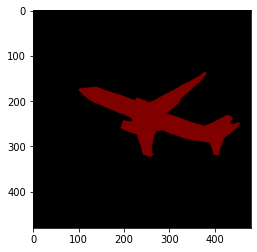

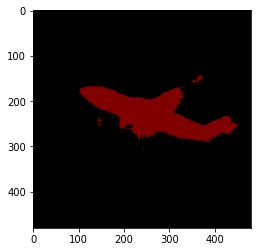

In [ ]:
## Test model

sample = train_dataset.take(10)
for X, y in sample:
  
  utils.display_image(X)
  utils.display_image(y)

  y_pred = model.predict(X[np.newaxis,:,:,:])
  utils.display_image(y_pred[0])